<a href="https://colab.research.google.com/github/brianmsm/curso-redes-neuronales-ucm/blob/main/PRACTICA_03_Regresion_con_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="darkorange" size="10"><b>03. Regresión con MLP</b></font>

Miguel A. Castellanos

En este cuaderno vamos a construir nuestras primeras redes neuronales usando **pytorch**, vete fijándote en el código y en las explicaciones que se adjuntan porque la mayoría del código se puede reutilizar, de hecho, un buen consejo es preparar tu propio **"*manual*"** con las partes de código y explicaciones que creas relevantes.

Vamos a empezar por las redes más sencillas, los __perceptrones multicapa__, exactamente iguales que los que hemos estado utilizando en [playground](https://playground.tensorflow.org/).

La tarea es identica a la realizada en playground, **predecir unos valores cuantitativos**, pero ahora en vez de ser un sandbox completamente opaco vamos a programar nuestras redes en tiempo real con todo el control.

__No te frustres__, a veces escribir código es frustrante porque te da la sensación de que unas veces funciona y otras no. Los ordenadores son deterministas, no tienen opiniones ni les caes mal; si antes te ha funcionado y ahora no es porque hay algo diferente, sigue intentándolo y si ves que no lo consigues consulta con un compañero o con el profesor.

En general, los ejercicios siempre están basados en cosas que han sido explicadas en clase, cuando haya un ejercicio que no te salga, relee los materiales y fíjate despacio en el código previo, es posible que la solución la tengas a la vista. Si aún así no encuentras la solución pregunta a tus compañeros y __no dudes en contactar conmigo__.

Lo primero que vamos a hacer es cargar un montón de paquetes y librerías de python que vamos a necesitar para que se calculen las redes. No te preocupes por esta parte, no es necesario entender qué o cómo lo hace, simplemente ejecútala. Lo que hace este código es:

Carga los paquetes: numpy, tensorflow2, panda, matplolib, pytorch y sklearn. Son paquetes básicos para el trabajo con datos y los paquetes relacionados con Deep Learning.
Para ejecutar un código puedes pinchar en la flecha de la celda o usar Ctr+Enter en el teclado.

## Empezamos trabajando con los datos

In [80]:
# Importamos las librerias que vamos a necesitar

import numpy as np
import matplotlib.pyplot as plt
import sklearn
import torch

In [81]:
# Generamos unos datos de X e y usando numpy

X = np.array(
    [258.0, 270.0, 294.0, 320.0, 342.0, 368.0, 396.0, 446.0, 480.0, 586.0]
)[:, np.newaxis]

y = np.array(
    [236.4, 234.4, 252.8, 298.6, 314.2, 342.2, 360.8, 368.0, 391.2, 390.8]
)

Un consejo, las nomenclaturas de las variables son libres, pero se recomienda que sean coherentes, por ejemplo, a veces se les llama X (en mayúscula) e y, otras veces features and labels (o targets).

Lo que te recomiendo es que elijas la tuya y escribas tu código siendo coherente con ella, luego cuando tengas que buscar ***bugs*** y errores te harás menos lío.

Yo voy a usar X e y en esta práctica.

In [82]:
# Comprobamos que se han creado bien

print(X)
print(y)

[[258.]
 [270.]
 [294.]
 [320.]
 [342.]
 [368.]
 [396.]
 [446.]
 [480.]
 [586.]]
[236.4 234.4 252.8 298.6 314.2 342.2 360.8 368.  391.2 390.8]


Fíjate que y es un vector pero X es una matriz de 10 filas y una columna.

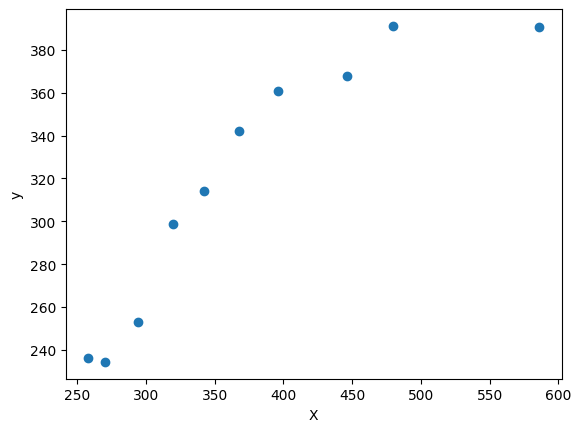

In [83]:
# Ploteamos X e y

plt.scatter(X, y)
plt.xlabel("X")
plt.ylabel("y")
plt.show()

In [84]:
# Vamos a utilizar la funcion LinearRegression del paquete sklearn para calcular la recta a esos puntos

from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X, y)

# create predictions for plotting
X_range = np.arange(250, 600, 10)[:, np.newaxis] # de nuevo creamos una matrix nx1 en vez de un vector
y_linear = lr.predict(X_range)

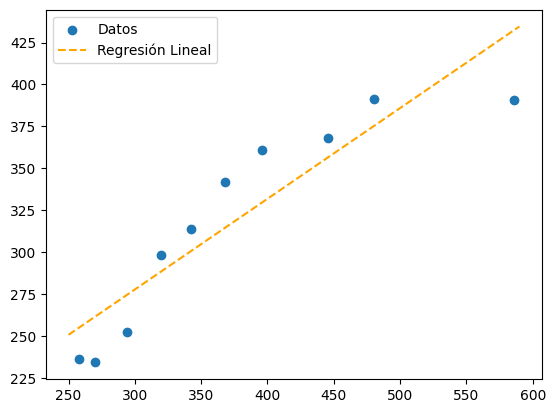

In [85]:
# Dibujamos tanto los puntos como la recta

plt.scatter(X, y, label="Datos")
plt.plot(X_range, y_linear, label="Regresión Lineal", linestyle="--", color="orange")
plt.legend()
plt.show()

Ya tenemos los datos y la predicción que se puede hacer con una recta de regresión, ahora vamos a construir una MLP para ver cómo mejoramos la predicción.

## Vamos a preparar los datos

- Lo primero es hacer la normalización de X e y
- Luego se crea un dataset formado por tensores y que sea iterable

**Respecto a la normalización:**

- En Keras la estrategia es normalizar X y dejar y en su escala, poniendo una función de activación lineal que reescale desde los pesos de la red a la escala original de y
- En pytorch no se recomienda, se elimina esa última capa y se deja en la misma escala que los pesos. Posteriormente, cuando se termina de entrenar, se devuelven las predicciones a la misma escala

**Respecto a la construcción del dataset:**

- Ahora viene una parte extraña, como pytorch tiene que usar tensores y nosotros hemos creados los datos usando numpy hay que convertirlos. Para ello se usa la funcion ***TensorDataset***
- Además, es necesario hacer que nuestros datos sean iterables, es decir, que puedan utilizarse uno a uno por la red para entrenarla, esto se hace con la función ***DataLoader***

Ambas funciones tienen su complejidad (manejar los datos es más complejo que estimar la red) y poco a poco aprenderemos a sacarles más provecho.

In [86]:
# preparamos los datos

from torch.utils.data import TensorDataset, DataLoader

# Normalizamos X e y
x_mean, x_std = X.mean(), X.std()
y_mean, y_std = y.mean(), y.std()

X_norm = (X - x_mean) / x_std
y_norm = (y - y_mean) / y_std

# Pasamos las variables a tensores
tensor_X = torch.Tensor(X_norm) # transform to torch tensor
tensor_y = torch.Tensor(y_norm)

# Creamos el dataset y el dataloader
my_dataset = TensorDataset(tensor_X,tensor_y) # create your datset
my_dataloader = DataLoader(my_dataset) # create your dataloader

## Ahora vamos a definir la red

Es una red cutrecilla

Definimos la red como una clase, es lo recomendado
vamos a crear una red con:
- Una entrada con las dimensiones de X
- Una única capa con una neurona
- Una de salida con una unica neurona sin activación


In [87]:
# Definimos la red como una clase, es lo recomendado
# vamos a crear una red con:
#   - Una entrada con las dimensiones de X
#   - Una capa oculta de 1 neurona
#   - Una de salida con una unica neurona sin activación


class MLP(torch.nn.Module):
    def __init__(self, X_nvars):
        super().__init__()

        self.layers = torch.nn.Sequential(

            # Hidden Layer 1
            torch.nn.Linear(X_nvars, 1), # Hacemos el sumatorio
            torch.nn.ReLU(),              # Aplicamos la función de activacion

            # output layer
            torch.nn.Linear(1, 1),
        )

    def forward(self, x):
        output = self.layers(x)
        return output

## Creamos la red y definimos los Hiper-parámetros

In [89]:
# Fijamos la semilla a un valor para que los resultados sean identicos
torch.manual_seed(1)

# Ahora fijamos algunos hiper-parámetros

# Creamos el modelo MLP
model = MLP(X_nvars=1)

# Definimos la función loss
loss_fn = torch.nn.MSELoss()

# Elegimos el optimizador
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)


## Ahora hacemos el entrenamiento de la red

In [90]:
import torch.nn.functional as F

# Fijamos el número de épocas o iteraciones
num_epochs = 200

# Una variables donde vamos a ir guardando los valores del loss para ploterarlos
loss_history = []

for epoch in range(num_epochs):
    model = model.train() # se fijan algunas cosas para hacer entrenamiento

    # En esta parte se define el batch
    # No te preocupes que aún no sabemos qué es
    # MUY IMPORTANTE, nunca uses el mismo nombre que tus datos o los sobreescribe
    for batch_idx, (features, targets) in enumerate(my_dataloader):

        output = model(features)            # Hacemos el forward
        loss = loss_fn(output, targets)     # Calculamos el loss

        optimizer.zero_grad()        # Ponemos a cero el gradiente
        loss.backward()              # Calculamos los gradientes (la derivada del loss)
        optimizer.step()             # Cambiamos los pesos de la red

        # Cada cierto tiempo vamos a imprimir un poco de información
        # para saber qué está pasando
        if not batch_idx % 100:
            print(
                f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
                # f" | Batch {batch_idx:03d}/{len(train_loader):03d}"
                f" | Batch {batch_idx:03d}/{len(my_dataloader):03d}"
                f" | Train Loss: {loss.item():.2f}"
            )
        # añadimos el loss a loss_history
    loss_history.append(loss.item())

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 001/200 | Batch 000/010 | Train Loss: 3.56
Epoch: 002/200 | Batch 000/010 | Train Loss: 3.97
Epoch: 003/200 | Batch 000/010 | Train Loss: 3.95
Epoch: 004/200 | Batch 000/010 | Train Loss: 3.93
Epoch: 005/200 | Batch 000/010 | Train Loss: 3.92
Epoch: 006/200 | Batch 000/010 | Train Loss: 3.91
Epoch: 007/200 | Batch 000/010 | Train Loss: 3.89
Epoch: 008/200 | Batch 000/010 | Train Loss: 3.85
Epoch: 009/200 | Batch 000/010 | Train Loss: 3.74
Epoch: 010/200 | Batch 000/010 | Train Loss: 3.33
Epoch: 011/200 | Batch 000/010 | Train Loss: 2.60
Epoch: 012/200 | Batch 000/010 | Train Loss: 2.14
Epoch: 013/200 | Batch 000/010 | Train Loss: 2.05
Epoch: 014/200 | Batch 000/010 | Train Loss: 1.78
Epoch: 015/200 | Batch 000/010 | Train Loss: 1.52
Epoch: 016/200 | Batch 000/010 | Train Loss: 1.53
Epoch: 017/200 | Batch 000/010 | Train Loss: 1.35
Epoch: 018/200 | Batch 000/010 | Train Loss: 1.42
Epoch: 019/200 | Batch 000/010 | Train Loss: 1.24
Epoch: 020/200 | Batch 000/010 | Train Loss: 1.24


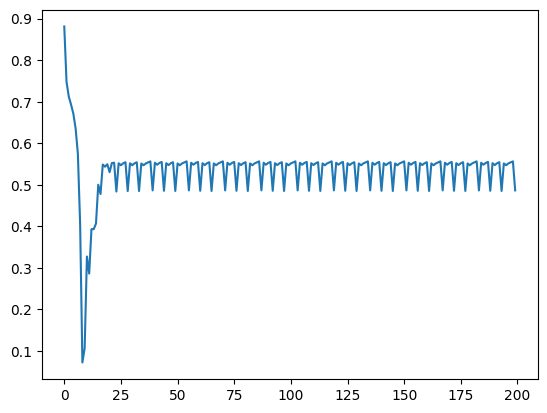

In [91]:
# Vamos a hacer un plot del loss, a ver qué ha pasado

plt.plot(loss_history)

In [92]:
# Vamos a evaluar el funcionamiento del modelo

model.eval() # se fijan parametros del modelo para evaluar

# predecimos los valores del rango X_range segun el MLP

# Se pasan a un tensor normalizado
X_range_norm = (X_range - x_mean) / x_std
X_range_norm = torch.tensor(X_range_norm, dtype=torch.float32)

# Se meten en el modelo
y_mlp_norm = model(X_range_norm)

# Ahora se desnormalizan para que estén en la misma escala
y_mlp_norm = y_mlp_norm.detach().numpy().astype(np.float64) # dejan de ser un tensor
y_mlp = y_mlp_norm * y_std + y_mean # desnormalizan


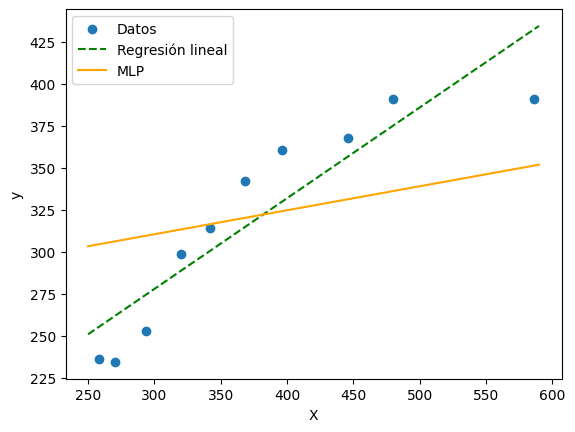

In [93]:
# Vamos a hacer un plot con los resultados

# Los datos originales
plt.scatter(X, y, label="Datos")

# Los datos predichos por la regresion lineal
plt.plot(X_range, y_linear, label="Regresión lineal", linestyle="--", color='green')

# Los datos predichos por el MLP
plt.plot(X_range, y_mlp, label="MLP", color='orange')

plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

---
# Ejercicios

Crea un notebook de colab con las soluciones a los ejercicios, hazlo público y sube el enlace al campus virtual




### 01. Ejercicio 1

Con los datos de este ejemplo crea una red neuronal que sea capaz de generar un error de cero (es decir, la linea de MLP atraviesa todos los puntos).

Definimos 5 capas (4 con activaciones Tanh y 1 de salida sin activación) con las siguientes características:

*   Se ha optado por Tanh en lugar de ReLU para garantizar que la salida de cada capa tenga valores tanto positivos como negativos, lo que puede ser beneficioso en modelos de regresión.
*   La estructura en forma de embudo (disminuyendo la cantidad de neuronas en cada capa) permite condensar la información gradualmente, evitando sobreajuste y mejorando la generalización del modelo.

In [102]:
class MLP(torch.nn.Module):
    def __init__(self, X_nvars):
        super().__init__()
        self.layers = torch.nn.Sequential(
            # Capa oculta 1 (mayor capacidad)
            torch.nn.Linear(X_nvars, 50),
            torch.nn.Tanh(),

            # Capa oculta 2 (no linealidad adicional)
            torch.nn.Linear(50, 40),
            torch.nn.Tanh(),

            # Capa oculta 3 (no linealidad adicional)
            torch.nn.Linear(40, 25),
            torch.nn.Tanh(),

            # Capa oculta 4 (no linealidad adicional)
            torch.nn.Linear(25, 10),
            torch.nn.Tanh(),

            # Capa de salida
            torch.nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.layers(x)

- Se utiliza la función MSELoss (Mean Squared Error, Error Cuadrático Medio).
- Se usa el optimizador Adam (Adaptive Moment Estimation) en lugar del SGD (Gradiente Descendente Estocástico) estándar.
- Se define el hiperparámetro de la tasa de aprendizaje en 0.001 que es el valor adecuado para Adam.



In [105]:
# Fijamos la semilla a un valor para que los resultados sean identicos
torch.manual_seed(1)

# Ahora fijamos algunos hiper-parámetros

# Creamos el modelo MLP
model = MLP(X_nvars=1)

# Definimos la función loss
loss_fn = torch.nn.MSELoss()

# Elegimos el optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Hacemos el entrenamiento

In [110]:
import torch.nn.functional as F

# Fijamos el número de épocas o iteraciones
num_epochs = 500

# Una variables donde vamos a ir guardando los valores del loss para ploterarlos
loss_history = []

for epoch in range(num_epochs):
    model = model.train() # se fijan algunas cosas para hacer entrenamiento

    # En esta parte se define el batch
    # No te preocupes que aún no sabemos qué es
    # MUY IMPORTANTE, nunca uses el mismo nombre que tus datos o los sobreescribe
    for batch_idx, (features, targets) in enumerate(my_dataloader):

        output = model(features)            # Hacemos el forward
        loss = loss_fn(output, targets)     # Calculamos el loss

        optimizer.zero_grad()        # Ponemos a cero el gradiente
        loss.backward()              # Calculamos los gradientes (la derivada del loss)
        optimizer.step()             # Cambiamos los pesos de la red

        # Cada cierto tiempo vamos a imprimir un poco de información
        # para saber qué está pasando
        if not batch_idx % 100:
            print(
                f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
                # f" | Batch {batch_idx:03d}/{len(train_loader):03d}"
                f" | Batch {batch_idx:03d}/{len(my_dataloader):03d}"
                f" | Train Loss: {loss.item():.2f}"
            )
        # añadimos el loss a loss_history
    loss_history.append(loss.item())

Epoch: 001/500 | Batch 000/010 | Train Loss: 0.00
Epoch: 002/500 | Batch 000/010 | Train Loss: 0.00
Epoch: 003/500 | Batch 000/010 | Train Loss: 0.00
Epoch: 004/500 | Batch 000/010 | Train Loss: 0.00
Epoch: 005/500 | Batch 000/010 | Train Loss: 0.00
Epoch: 006/500 | Batch 000/010 | Train Loss: 0.00
Epoch: 007/500 | Batch 000/010 | Train Loss: 0.00
Epoch: 008/500 | Batch 000/010 | Train Loss: 0.00
Epoch: 009/500 | Batch 000/010 | Train Loss: 0.00
Epoch: 010/500 | Batch 000/010 | Train Loss: 0.00
Epoch: 011/500 | Batch 000/010 | Train Loss: 0.00
Epoch: 012/500 | Batch 000/010 | Train Loss: 0.00
Epoch: 013/500 | Batch 000/010 | Train Loss: 0.00
Epoch: 014/500 | Batch 000/010 | Train Loss: 0.00
Epoch: 015/500 | Batch 000/010 | Train Loss: 0.00
Epoch: 016/500 | Batch 000/010 | Train Loss: 0.00
Epoch: 017/500 | Batch 000/010 | Train Loss: 0.00
Epoch: 018/500 | Batch 000/010 | Train Loss: 0.00
Epoch: 019/500 | Batch 000/010 | Train Loss: 0.00
Epoch: 020/500 | Batch 000/010 | Train Loss: 0.00


Observamos que el train loss cae a 0. Aunque el entrenamiento es inestable, se cumple el objetivo de obtener un modelo sin pérdida.

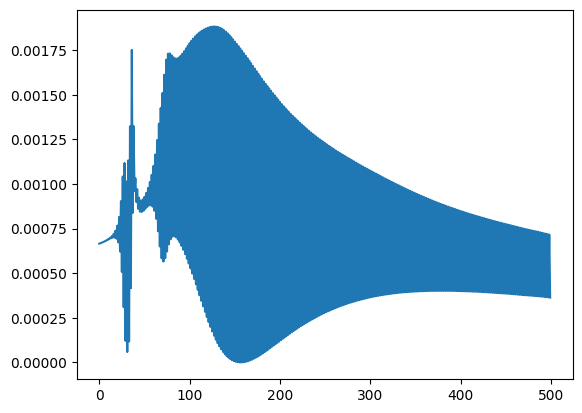

In [111]:
# Vamos a hacer un plot del loss, a ver qué ha pasado

plt.plot(loss_history)

In [112]:
# Vamos a evaluar el funcionamiento del modelo

model.eval() # se fijan parametros del modelo para evaluar

# predecimos los valores del rango X_range segun el MLP

# Se pasan a un tensor normalizado
X_range_norm = (X_range - x_mean) / x_std
X_range_norm = torch.tensor(X_range_norm, dtype=torch.float32)

# Se meten en el modelo
y_mlp_norm = model(X_range_norm)

# Ahora se desnormalizan para que estén en la misma escala
y_mlp_norm = y_mlp_norm.detach().numpy().astype(np.float64) # dejan de ser un tensor
y_mlp = y_mlp_norm * y_std + y_mean # desnormalizan

Se observa explicación perfecta

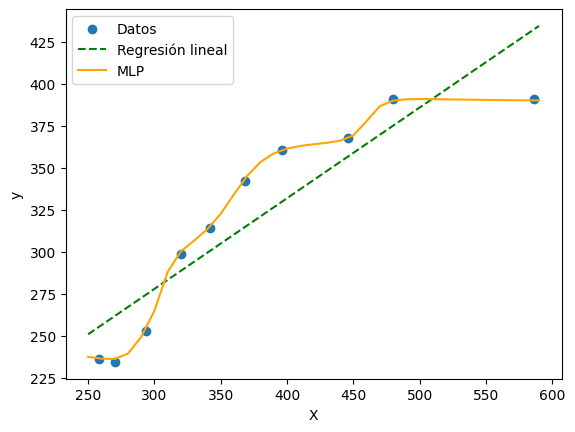

In [113]:
# Vamos a hacer un plot con los resultados

# Los datos originales
plt.scatter(X, y, label="Datos")

# Los datos predichos por la regresion lineal
plt.plot(X_range, y_linear, label="Regresión lineal", linestyle="--", color='green')

# Los datos predichos por el MLP
plt.plot(X_range, y_mlp, label="MLP", color='orange')

plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

### 02. Ejercicio 2

Usando el código siguiente, construye un MLP que se ajuste razonablemente a los puntos de ese seno. Puedes jugar con la creación de datos.


In [ ]:
# Creamos los datos, en este caso un seno

import numpy as np

cycles = 2  # numero de periodos
n = 100     # numero de datos en x

length = 2 * np.pi * cycles

x = np.arange(0, length, length / n)
y = np.sin(x)

plt.plot(x, y, '-')

print(x.shape)
print(y.shape)

### 03. Ejercicio 3

Regresión con datos de felicidad

Se analizan unos datos obtenido de Kaggle.com sobre la encuesta de felicidad de 2021: [enlace](https://https://www.kaggle.com/datasets/ajaypalsinghlo/world-happiness-report-2021)

Una vez limpiados y preparados la base de datos consta de 9 variables predictoras y una variable criterio:

**Criterio**: Life.Ladder.

**Predictoras**: year, Log.GDP.per.capita, Social.support, Healthy.life.expectancy.at.birth, Freedom.to.make.life.choices, Generosity, Perceptions.of.corruption, Positive.affect, Negative.affect.


In [ ]:
# Funciones para importar y preparar los datos

import pandas as pd
url = 'https://raw.githubusercontent.com/mcstllns/UNIR2024/main/data-happiness.csv'
data  = pd.read_csv(url)
print(data.keys())
data.head()

# El fichero tiene datos perdidos y hay que eliminar las filas
data = data.dropna()

# Creamos conjuntos X e y
X = data.drop('Life.Ladder', axis=1)
y = data['Life.Ladder']

print(X.head())
print(y.head())


In [ ]:
# preparamos los datos

from torch.utils.data import TensorDataset, DataLoader

# Normalizamos X e y
x_mean, x_std = X.mean(), X.std()
y_mean, y_std = y.mean(), y.std()

X_norm = (X - x_mean) / x_std
y_norm = (y - y_mean) / y_std

# Pasamos las variables a tensores
# Ojo, como son dataframes de pandas la sintaxis es un poco diferente

tensor_X = torch.from_numpy(X_norm.values)
tensor_y = torch.from_numpy(y_norm.values)

# Creamos el dataset y el dataloader
my_dataset = TensorDataset(tensor_X,tensor_y) # create your datset
my_dataloader = DataLoader(my_dataset) # create your dataloader

In [ ]:
print(tensor_X.shape)
print(tensor_y.shape)

Ahora ya se puede calcular la red

Ojo: NO intentes hacer un plot de X, y porque ahora X tiene 9 variables

El mejor modelo calculado con estadística convencional (modelo lineal) da un **MSE de 0.235**

**Supera el MSE de la regresión múltiple**
